<center>
    <h2>Computational Statistics <br> Extension de l'algorithme SAEM pour des données manquantes </h2> 08 / 12 / 2023<br> Prof. Stéphanie Allassonnière <br>
 <br> <br>
Vincent Herfeld, Simon Queric
</center>


### Modèle non linéaire à effets mixtes

On observe la charge virale de $N$ individus sur une période de temps : 

\begin{equation*}
    \begin{cases}
        y_{i,j} &= f(\phi_i, t_{i,j}) + \varepsilon_{i,j} \\
        \varepsilon_{i,j} &\sim \mathcal{N}(0, \sigma^2 I_n) \\
        \phi_i &= \mu + b_i, b_i \sim \mathcal{N}(0, \Omega)
    \end{cases}
\end{equation*}

De plus, on suppose que lorsqu'une mesure $y_{i,j}$ est en dessous d'un seuil $LOQ$, la valeur n'est pas réellement observée.

La log-vraissemblance des données (observées et non observées) s'écrit : 

\begin{equation*}
    \begin{aligned}
    \log{p(y, \phi, \theta)} &= \log{p(y, \theta \mid \phi)} + \log{p(\phi)} \\
                             &= - NK\log{\sigma} + \sum_{i=1}^N\sum_{j=1}^K{-\frac{(y_{i,j} - f(\phi_i, t_{i,j}))^2}{2\sigma^2}} \\
                             & + \sum_{i=1}^N{-\frac{(\phi_i-\mu)^T\Omega^{-1}(\phi_i - \mu)}{2}} - N\log\det{\Omega}/2
    \end{aligned}
\end{equation*}

Les données manquantes sont les données de $z=(\phi, y^{cens})$  et les paramètres sont $\theta = ( \log{P_1}, \log{P_2}, \log{\lambda_1}, \log{\lambda_2}, \Omega, \sigma^2) = (\mu, \Omega, \sigma^2)$. 

$\Omega = \omega^2I_4$


Cette log-vraissemblance appartient à la famille des modèles exponentiels courbes.

En effet, on peut la réecrire sous la forme : 

\begin{equation*}
    \log{p(y, \phi, \theta)} = -\Lambda(\theta) + \langle S(y, z), \varphi(\theta) \rangle
\end{equation*}

où 


\begin{cases}
\displaystyle
\Lambda(\theta) &= NK\log{\sigma} + N\log\det\Omega + N\mu^T\mu/2\omega^2 \\
\varphi(\theta) &= (\mu/\omega^2, -1/2\omega^2, -1/2\sigma^2)^T\\ 
S(y, z) &= \left(\sum_{i=1}^N{\phi_i}, \sum_{i=1}^N{\phi_i^T\phi_i, \sum_{i,j}{(y_{i,j} - f(\phi_i, t_{i,j})^2)}}\right) \\
\end{cases}


La fonction $f$ est définie par :

$$ f(\phi, t) = \log_{10}{(P_{1}e^{-\lambda_1 t} + P_{2}e^{-\lambda_2 t})} $$

Elle représente la décroissance de la charge virale après l'administration d'un traitement, modèle proposé par [?]. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

In [2]:
def f(phi, i, t) :
    return np.log10(np.exp(phi[i, 0] - np.exp(phi[i, 2])*t) + np.exp(phi[i, 1] - np.exp(phi[i, 3])*t))

In [3]:
def generate_data(mu, Omega, sigma2=0.065**2, N=40, t=np.array([1, 3, 7, 14, 28, 56])) :
    n = len(t)
    y = np.zeros((N, n))
    b = np.random.multivariate_normal(mean=np.zeros_like(mu), cov=np.diag(Omega), size=(N))
    phi = mu + b
    eps = np.random.multivariate_normal(mean=np.zeros(n), cov=sigma2*np.eye(n), size=(N))
    for i in range(N) : 
        y[i] = f(phi, i, t)
    y = y + eps
    return y

In [4]:
t = np.array([1, 3, 7, 14, 28, 56]) #np.arange(0, 7)
K = len(t)
mu = np.array([12.2, 7.8, np.log(0.5), np.log(0.05)])
omega = 0.3*np.ones(4)
sigma2 = 0.065**2
N = 40
LOC = np.log10(400) # 2.6
y = generate_data(mu=mu, Omega=omega, sigma2=sigma2, N=N, t=t)
I = np.zeros((N, K))
I[y<=LOC] = 1 # 1 if censored else 0

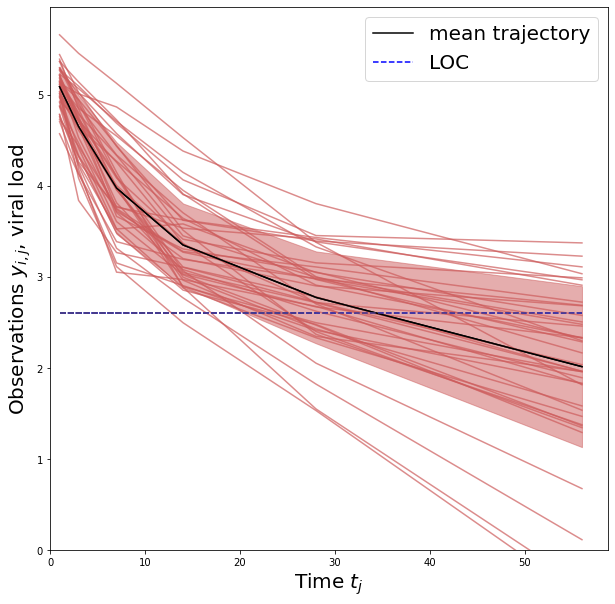

In [5]:
k = len(y[0])
fig = plt.figure(figsize=(10, 10))
y_mean = y.mean(axis=0)
y_std = y.std(axis=0)
plt.plot(t, y_mean, "k")
plt.hlines(LOC*np.ones(k), 1, t, linestyles='--', color="blue", label="LOC")
for n in range(N) :
    plt.plot(t, y[n,:], alpha=0.7, color="indianred", ls="-")
plt.plot(t, y_mean, "k")
plt.hlines(LOC*np.ones(k), 1, t, linestyles='--', color="darkslateblue", label="LOC")
plt.fill_between(t, y_mean-y_std, y_mean+y_std, alpha=0.5, color="indianred")
plt.legend(["mean trajectory", "LOC"], fontsize=20)
plt.xlabel("Time $t_j$", fontsize=20)
plt.ylabel("Observations $y_{i, j}$, viral load", fontsize=20)
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.show()

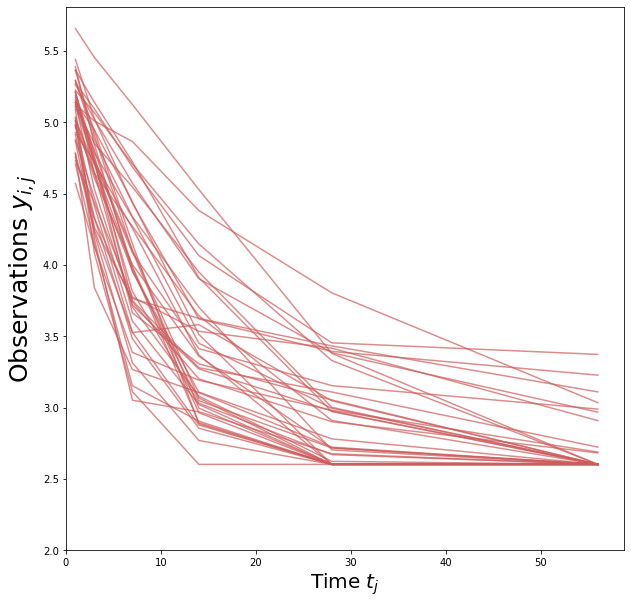

In [6]:
y_truncated = y*(y>=LOC) + LOC*(y<LOC)
fig = plt.figure(figsize=(10, 10))
for n in range(N) :
    plt.plot(t, y_truncated[n,:], alpha=0.7, color="indianred", ls="-")
plt.xlabel("Time $t_j$", fontsize=20)
plt.ylabel("Observations $y_{i, j}$", fontsize=25)
plt.ylim(ymin=2)
plt.xlim(xmin=0)
plt.show()

## Algorithme SAEM

### Initialisation 

Initialisation de $\widehat{\theta}_0$.

### Étape SAE

1. Simulation de $z^{(m)} = (\phi^{(m)}, y_{cens}^{(m)})$

2. $s_m = s_m + \gamma_m(S(y, z^{(m)}) - s_{m-1})$

### Étape M

Calcule de $\widehat{\theta}_m = \underset{\theta\in \Theta}{\text{argmax}} \left( -\Lambda(\theta) + \langle s_m, \varphi(\theta) \rangle \right) $

\begin{cases}
\widehat{\mu}_m &= \frac{1}{N}s_m^{(1)} \\
\widehat{\omega^2}_m &= \frac{1}{dN}\sum_{i=1}^N{(\phi_i-\widehat{\mu}_m)^T(\phi_i-\widehat{\mu}_m)} \\
\widehat{\sigma^2}_m &= \frac{1}{NK}s_m^{(3)}\\ 
\end{cases}

## Algorithme de Gibbs pour simuler les données manquantes

À l'étape $m$ de l'algorithme SAEM, on simule $z^{(m)} \sim p(\cdot \mid y_{obs}, \widehat{\theta}_{m-1})$ en deux étapes : 
1. $\phi^{(m)} \sim p(\cdot \mid y_{obs}, y^{(m-1)}_{cens}, \widehat{\theta}_{m-1})$ avec Metropolis Hasting
2. $y_{cens}^{(m)} \sim p(\cdot \mid y_{obs}, \phi^{(m)}, \widehat{\theta}_{m-1})$ avec une loi normal tronquée à droite de $LOC$ par méthode de rejet (avec une exponentielle translatée).

On calcule la probabilité conditionnelle à une constante additive près :

$$ \log{p(\phi \mid y, \theta)} = \sum_{i, j}{-\frac{(y_{i,j} - f(\phi_i, t_{i,j}))^2}{2\sigma^2}} + \sum_{i=1}^N{-\frac{(\phi_i - \mu)^T\Omega^{-1}(\phi_i - \mu)}{2}}$$ 


### ToDO 

#### 1. Simulation d'une loi normale tronquée à droite

#### 2. Simulation de la loi conditionnelle de $\phi$

In [207]:
jit(nopython=True)
def S(y, phi) : 
    N = len(y) 
    S1 = phi.sum(axis=1)
    S2 = np.sum(phi**2)
    S3 = 0
    for i in range(N) : 
        S3 += (y[i] - np.log10(np.exp(phi[i, 0] - np.exp(phi[i, 2])*t) + np.exp(phi[i, 1] - np.exp(phi[i, 3])*t)))**2
    S = np.zeros(len(S1)+2)
    S[:-2] = S1
    S[-2] = S2
    S[-1] = S1
    return S

In [208]:
@jit(nopython=True)
def truncated_gaussian(m, sigma, LOC) :
    """
    Generate a right-truncated gaussian distribution of mean m
    """
    C=(m-LOC)/sigma
    alpha = (C+np.sqrt(C**2+4))/2

    u = np.random.uniform(0, 1)
    x = -1/alpha * np.log(1 - u) + C
    rho = np.exp(-(x-alpha)**2/2)
    u = np.random.uniform(0, 1)
    while u > rho :
        u = np.random.uniform(0, 1)
        x = -1/alpha * np.log(1 - u) + C
        rho = np.exp(-(x-alpha)**2/2)
        u = np.random.uniform(0, 1)
            
        
    y = m - sigma*x
        
    return y

In [209]:
n_iter = 1000
m = 2
LOC = 5
sigma = 2
X = np.zeros(n_iter)
for n in range(n_iter) :
    X[n] = truncated_gaussian(m=m, sigma=sigma, LOC=LOC)

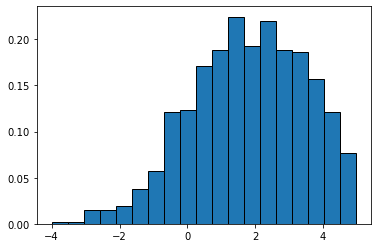

In [210]:
plt.hist(X, bins='auto', density=True, edgecolor="k")
plt.show()

In [215]:
indexes = np.where(I==1)
I_cens = []
for i,j in zip(indexes[0], indexes[1]) :
    I_cens.append((i, j))

In [219]:
print(I_cens)

[(0, 4), (0, 5), (1, 5), (2, 4), (2, 5), (3, 5), (4, 5), (5, 4), (5, 5), (6, 5), (9, 4), (9, 5), (10, 3), (10, 4), (10, 5), (11, 5), (12, 4), (12, 5), (14, 4), (14, 5), (15, 5), (17, 5), (18, 5), (19, 5), (20, 5), (21, 5), (25, 5), (26, 4), (26, 5), (27, 4), (27, 5), (28, 5), (29, 4), (29, 5), (30, 4), (30, 5), (31, 5), (33, 5), (34, 4), (34, 5), (35, 5), (37, 5), (38, 4), (38, 5)]


In [204]:
@jit(nopython=True)
def log_pi(phi, param) :
    y = np.copy(param[0])
    theta = np.copy(param[1])
    mu, omega2, sigma2 = theta[:4] = theta[4], theta[5]
    t = np.copy(param[2])
    N, K = y.shape
    log_p = 0
    for i in range(N):
        log_p -= (phi[i] - mu).T@(phi[i]-mu)/(2*omega2)
        for j in range(K):
            log_p -= (y[i,j]-f(phi[i], t[i,j]))**2/(2*sigma2)

    return log_p    

In [191]:
x = np.zeros(100)
d = np.shape(x)
d[0]

100

In [205]:
@jit(nopython=True)
def log_p(x, mu, sigma2) :
    return -(x-mu).T@(x-mu)/(2*sigma2)

In [203]:
@jit(nopython=True)
def metropolis_hasting(z0, log_pi, param, mu, omega2, n_iter) :
    z = np.copy(z0)
    d = z.shape
    for n in range(n_iter) :
        y = np.zeros(d)
        for i in range(d) :
            y[i] = np.random.normal(loc=mu[i], scale=np.sqrt(omega2))
        acc_rate = np.exp(min(0, log_pi(y, param) - log_pi(z, param) + log_p(y, mu, omega2) - log_p(z, mu, omega2)))
        u = np.random.uniform(0, 1)
        if u <= acc_rate :
            z = y
    return z

In [202]:
def Gibbs_SAEM(theta0, y, t, I_cens, LOC, N, K, M1=3000, M2=1000, hm_iter=100):
    """
    SAEM algorithm implementation to find the MAP of the model    
    """
    theta = np.copy(theta0)
    Y = np.copy(y)
    phi = np.zeros((N, 4))
    sm = 0
    for m in range(1, M1+M2):
        if m<=M1:
            gamma = 1
        else :
            gamma = 1/(m-M1)
        phi = metropolis_hasting(phi, log_pi, param=(Y, theta, t), mu=theta[:4], omega2=theta[4], n_iter=hm_iter)
        for (i,j) in I_cens :
            Y[i,j] = truncated_gaussian(f(phi[i], t[i,j]), theta[-1], LOC)

        sm = sm + gamma*(S(Y, phi) - sm)
        theta[:4] = sm[:4]/N
        theta[5] = sm[5]/(N*K)
        theta[4] = 0
        for i in range(N):
            theta[4] += (phi[i]-theta[:4]).T@(phi[i]-theta[:4]) / (d*N)
         
    return theta, Y, phi

## Convergence empirique de l'algorithme SAEM